In [1]:
from os import initgroups
import torch
import time
from blase.datasets import HPFDataset
from blase.multiorder import MultiOrder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


# Change to 'cpu' if you do not have an NVIDIA GPU
# Warning, it will be about 30X slower.
device = "cpu"

dataset = HPFDataset('../test/data/Goldilocks_20191022T013208_v1.0_0003.spectra.fits')
data_cube = dataset.data_cube
model = MultiOrder(device=device, wl_data=data_cube[6, :, :])
model = model.to(device, non_blocking=True)


# Only send one frame per batch
n_frames_per_batch = 1
train_loader = DataLoader(dataset=dataset, batch_size=n_frames_per_batch, shuffle=True)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), 0.02)

n_epochs = 500

losses = []

t0 = time.time()
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    for i, data in enumerate(train_loader, 0):
        index, spectrum = data
        y_batch = spectrum.squeeze()
        model.train()
        yhat = model.forward(index.item()).squeeze()
        loss = loss_fn(yhat, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    t_iter.set_description(f"Loss {loss.item(): 15.3f}")
    t_iter.refresh()
    
# Save the model parameters for next time
t1 = time.time()
net_time = t1 - t0
print(f"{n_epochs} epochs on {device}: {net_time:0.1f} seconds", end="\t")


Loss           0.018:   4%|▍         | 20/500 [00:10<04:22,  1.83it/s]


KeyboardInterrupt: 

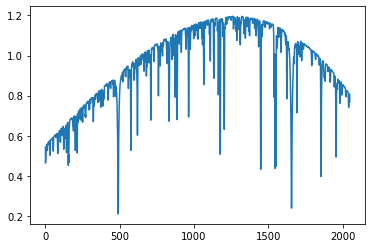

In [7]:
plt.plot(yhat.detach())